<a href="https://colab.research.google.com/github/ryanamundson1/MSDS/blob/main/MSDS-462/05_module05_pretrained_flower_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

To deploy a pretrained model on an edge device. In this suggested exploration, the target edge device is an android or iOS mobile phone.

# Suggested Exploration

The focus of this exercise is to take you through the steps involved in deploying a trained tensorflow model to a mobile phone. The accuracy or on-device performance of the model is not the central focus.

(Option 1) 
Follow the steps outlined in this [codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-android-beta/#0) to deploy a pre-trained flower classification model to an android device. Note that you could deploy the `tflite` model to an android emulator (i.e., deployment on a physical device is not mandatory).

(Option 2) Follow the steps outlined in this [codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-ios#0) to deploy a pre-trained flower classification model to an iOS device.

For both these options the task and the model are the same (i.e., flower classification). However, the target edge device is different. 

**IMPORTANT**

While following the model training tutorial presented in the above links, you might encounter CUDA errors due to a recent update in Tensorflow. 

Ensure that you use the code presented in the rest of the cells in this notebook to train your tflite model.

After following the steps in the rest of this notebook and dowloading the final `tflite` model, you can continue to the next step in the [option 1 - codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-android-beta/#2) or [option 2 - codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-ios#2).

# Step 1: Train and Save Model


## Imports

Update CUDA to avoid Tensorflow errors.

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 12s (36.6 MB/s)
(Reading database ... 122518 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122485 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [ ]:
!pip install -q tflite-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.4/642.4 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.1/642.1 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 26.3 MB/s

In [ ]:
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
print(tf.__version__)

## Data

The data set of flower images are hosted in a public GCP bucket. There are five vlasses of flowers in the dataset - daisy, dandelion, roses, sunflowers & tulips.


In [ ]:
image_path = tf.keras.utils.get_file(
      'flower_photos',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      untar=True)

228827136/228813984 [==============================] - 2s 0us/step


## Model


1.   Load input data specific to an on-device ML app. Split it to training data and testing data (here we are using a 90% - 10% split).

In [ ]:
data = DataLoader.from_folder(image_path)
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


2. Customize the TensorFlow model.

In [ ]:
model = image_classifier.create(train_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
103/103 [==============================] - 21s 138ms/step - loss: 0.8619 - accuracy: 0.7816
Epoch 2/5
103/103 [==============================] - 14s 132ms/step - loss: 0.6630 - accurac

3. Evaluate the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 5s 159ms/step - loss: 0.5856 - accuracy: 0.9319


4.  Export the final model to a TensorFlow Lite model. Once the model file is created, you could download it from the left bar to be used in the Android/iOS app.

In [ ]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: /tmp/tmpuvzracyv/assets


INFO:tensorflow:Assets written to: /tmp/tmpuvzracyv/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpfoml9xte/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpfoml9xte/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


5. Download the trained model by clicking on the folder icon on the left hand side. Right-click on "model.tflite" and select download. Or run the following code:

In [ ]:
from google.colab import files
files.download('model.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 2: Deploy (Optional)

After dowloading the final `model.tflite` model, continue to the next step in the [option 1 - codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-android-beta/#2) or [option 2 - codelab](https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-ios#2) to deploy this model on the respective edge devices.

**IMPORTANT**

Note that you will need to install the appropriate Android/iOS SDK components specific to the corresponding mobile operating system versions. 

If deployed on the device emulator, you can use your computers webcam as the camera input and the predictions from your model will be visible on the emulator itself (sample screenshot below). Note that the webcam input will always in landscape mode in the emulator.

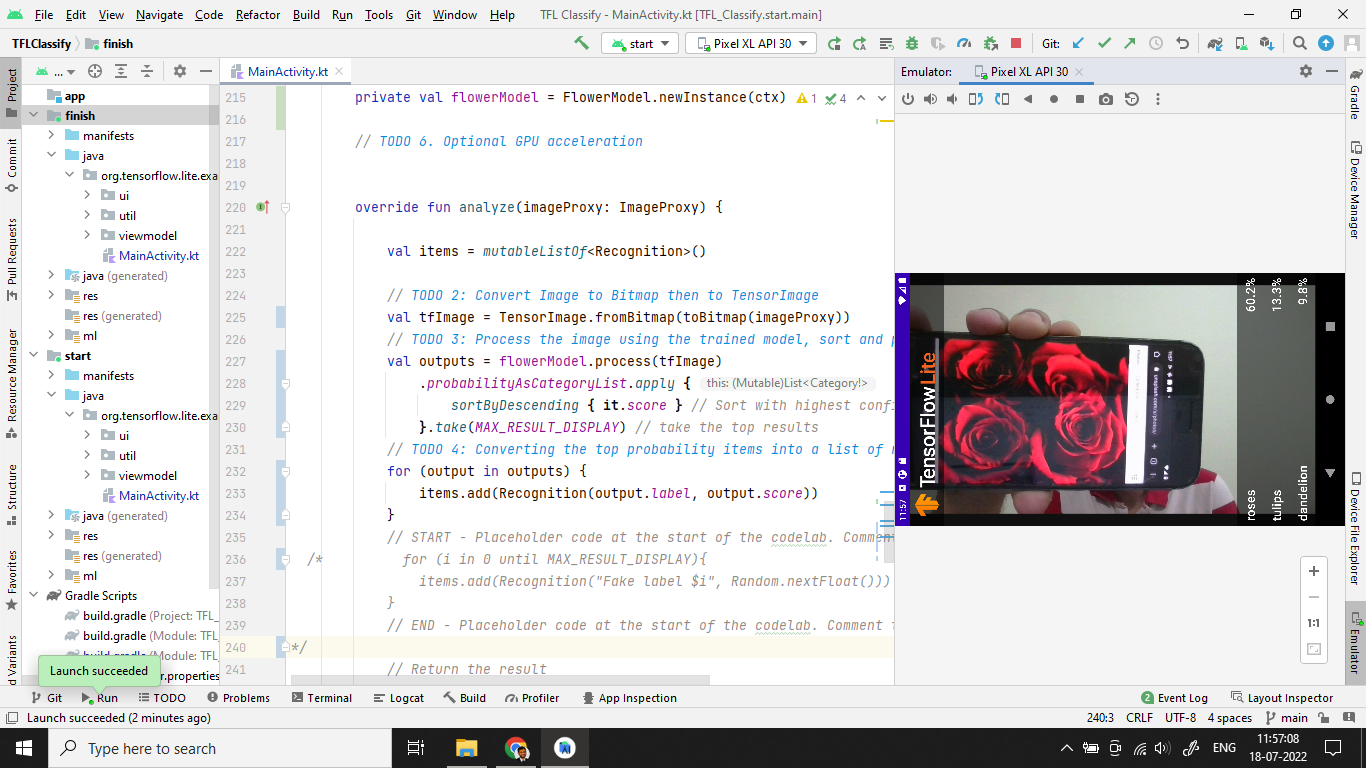

**(Optional Exploration)**

There are more pre-trained models available for deployment in the [Tensorflow examples GitHub page](https://github.com/tensorflow/examples).

Explore this [folder](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) in particular for ready-to-deploy image classification models.

